In [13]:
import numpy as np
import pandas as pd
import matplotlib as plt #ne pas semettre
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


import nltk
import spacy
import gensim
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import pickle
import unidecode


# Titles et Tags initiaux

In [40]:
#df1
post_df= pd.read_csv("Posts.csv").dropna(subset=['Title', 'Tags'])
df1 = post_df[(post_df["AnswerCount"].abs() > 10) & \
            (post_df["FavoriteCount"].abs() >  200) & \
            (post_df["ViewCount"].abs() > 5000)   & \
            (post_df["Score"].abs() > 15)]
#df2
PostsWithDeleted_df= pd.read_csv("PostsWithDeleted.csv").dropna(subset=['Title', 'Tags'])
df2 = PostsWithDeleted_df[(PostsWithDeleted_df["AnswerCount"].abs() > 10) & \
            (PostsWithDeleted_df["FavoriteCount"].abs() >  200) & \
            (PostsWithDeleted_df["ViewCount"].abs() > 5000)   & \
            (PostsWithDeleted_df["Score"].abs() > 15)]
#df3
df3= pd.read_csv("SuggestedEdits.csv").dropna(subset=['Title', 'Tags'])


#concat
df = pd.concat([df1[["Title", "Tags"]], df2[["Title", "Tags"]],df3[["Title", "Tags"]]])
df["Tags"] = df["Tags"].astype(str)
df = df.reset_index(drop=True)

df = df.drop(labels=['Tags'], axis=1)
print(df.shape)



df.head()

(2015, 1)


,Title
0,How do I calculate someone's age based on a Da...
1,Calculate relative time in C#
2,Versioning SQL Server database
3,How do you make sure email you send programmat...
4,The definitive guide to form-based website aut...


In [9]:
X_test= pd.read_csv('X_test_lda.csv', index_col =False)
X_test.set_index('Unnamed: 0', inplace=True)
X_test

X_train = pd.read_csv('X_test_lda.csv', index_col =False)
X_train.set_index('Unnamed: 0', inplace=True)
X_train

,Title
Unnamed: 0,
1404,break format nsstre multiple line
357,intellisense text script template
1344,problem post large amount datum web server iphone
913,delete post day old
1300,write mysql query look element key array
1284,integrate api iphone application
947,return integer objective iphone
1744,set size view
66,exist function jquery


# Normalisation des Titles

In [41]:
#TOKENIZER
data = df.Title.values.tolist()

def sent_to_words(sentences):
    
    '''
    sentences : list of sentences
    '''
    
    sentences = [re.sub(r"\'|/|<|>", " ", sent) for sent in sentences]
    sentences = [re.sub(r"#", 'diese', sent) for sent in sentences]
    sentences = [re.sub(r"\+", 'plus', sent) for sent in sentences]
    
   
    for sentence in sentences:
                
        # deacc= True removes punctuations
        #lowercase
        #remove one caracter only
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#data_words = list(sent_to_words(data))
#data_words #> List of list of words

In [42]:
#STOPWORDS
nltk.corpus.stopwords.words('english')

def stop_words(texts):
    '''
    texts : list of words - data_words
    corpus: list of sentences
    '''

    corpus = []
    for i in range(0,len(texts)):
        title = texts[i]
        #review = review.split() #list of words
        title = [word for word in title if not word in set(stopwords.words('english'))]
        title = ' '.join(title) #list of words to one sentence
        corpus.append(title)
        
    return corpus   

#stop_words(data_words)      #> list of sentences

In [10]:
X_train = pd.read_csv('X_test_lda.csv', index_col =False)
X_train.set_index('Unnamed: 0', inplace=True)
X_train


,Title
Unnamed: 0,
1404,break format nsstre multiple line
357,intellisense text script template
1344,problem post large amount datum web server iphone
913,delete post day old
1300,write mysql query look element key array
1284,integrate api iphone application
947,return integer objective iphone
1744,set size view
66,exist function jquery


In [43]:
#LEMMATIZATION
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
                   #data_words
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']): 
    '''
    texts : list of words
    '''
    texts_out = []
    for sent in texts:
        #words to sentence
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

#lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB'])

In [53]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data = df.Title.values.tolist()

def clean_titles(text, nlp=nlp):
    global sent_to_words
    global lemmatization
    '''
    text : list of sentence(s)
    '''

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text)) #> list of words
    
    #Step1_0 : stopwords
    mytext_3 = stop_words(mytext_2) #> list of sentences
    
    # Step 2: Lemmatize      
    liste=[]

    for element in mytext_3:
        title = element.split()
        liste.append(title)
        
        mytext_3 = liste #> list of words
        
                            #mytext_2 = data_words
    mytext_4 = lemmatization(mytext_3, allowed_postags=['NOUN', 'ADJ', 'VERB']) #> list of sentences

    #mytext_5 = count_SVD_vectorizer.transform(mytext_4)
    
    
    return mytext_4

#list to series
series = pd.Series(clean_titles(data, nlp=nlp), name = "Title")
series = series.astype('str', copy=False)

#series to df["Title"]
df_cleaned = series.to_frame()
df_cleaned = df_cleaned.dropna(axis=0)
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.shape)
df_cleaned.head()

(2015, 1)


,Title
0,calculate age base datetime type birthday
1,calculate relative time cdiese
2,versione server database
3,make sure email send mark spam
4,definitive guide form base website authentication


In [45]:
#list to series
series = pd.Series(clean_titles(data, nlp=nlp), name = "Title")
series = series.astype('str', copy=False)

#series to df["Title"]
df_cleaned = series.to_frame()
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.shape)
df_cleaned.head()

(2015, 1)


,Title
0,calculate age base datetime type birthday
1,calculate relative time cdiese
2,versione server database
3,make sure email send mark spam
4,definitive guide form base website authentication


# LDA

**Je charge les données splitées lors de l'entraînement des modèles.**

In [52]:
data_lemmatized = pd.read_csv('3.csv', index_col =False)
data_lemmatized = data_lemmatized.dropna(axis=0)
data_lemmatized = data_lemmatized.drop(data_lemmatized.iloc[:, 1:], axis=1)
print(data_lemmatized.shape)
data_lemmatized.head()

(2002, 1)


,Title
0,calculate age base datetime type birthday
1,calculate relative time cdiese
2,versione server database
3,make sure email send mark spam
4,definitive guide form base website authentication


In [54]:
#test size None,test size = 0.25 
#random_state= 42 to have the same output everytime I run
X_train, X_test= train_test_split(df_cleaned[["Title"]],random_state=42)

In [59]:
X_test["Title"]

1198                           error instal oracle window
526               remove padding margin datagridview cell
393                               start learn silverlight
1407                          create pdf thumbnail iphone
433                           parse local xml file io sdk
1720                             way convert map util map
1090                                                     
429                           plot move time series curve
1799                                   thread abort abort
530           texture issue draw triangale opengl android
1727                           api invalid datetime field
1453                                       implement tree
1293                             show tab widget activity
1618    use regular expression rail route make redirec...
1022                                                     
678            android screen wake timeout brightness set
1128                          load view button detailview
124           

In [56]:
X_test.shape

(504, 1)

In [136]:
from sklearn.decomposition import LatentDirichletAllocation
#Max_df=0.9 will remove words that appear in more than 90% of the reviews.
#Min_df=25 will remove words that appear in less than 25 reviews. 
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, 
                                   min_df =25, 
                                   
                                   # GridSearch: max number of uniq words 
                                   max_features=1000, 
                                   use_idf=False)

tfidf_vectorizer.fit(X_train["Title"])

feat_train = tfidf_vectorizer.transform(X_train["Title"])
feat_test = tfidf_vectorizer.transform(X_test["Title"])



'''
learning_method: if the data size is large, 
the online update will be much faster than the batch update
 '''
# Init the Model
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]} 

# Init Grid Search Class
lda = LatentDirichletAllocation(
    #The maximum number of iterations.
    max_iter=5, 
    learning_method='online', 
    #downweights early iterations in online learning.
    learning_offset=50.,
    #Pass an int for reproducible results 
    random_state=42)


gs = GridSearchCV(lda, 
                     #None, to use the default 5-fold cross validation,
                     cv=None, 
                     error_score='raise',
                     n_jobs=1,
                     param_grid=search_params,
               
                     return_train_score= True)

gs.fit(feat_train)

best_lda_model = gs.best_estimator_

In [148]:
#pickle.dump(best_lda_model, open('best_lda_model.pkl', 'wb'))
#best_lda_model = pickle.load(open('best_lda_model.pkl', 'rb'))
#best_lda_model

LatentDirichletAllocation(learning_decay=0.5, learning_method='online',
                          learning_offset=50.0, max_iter=5, random_state=42)

In [137]:
# Get the top 10 keywords each topic

def show_topics(vectorizer=tfidf_vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(tfidf_vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer=tfidf_vectorizer,
                             lda_model=best_lda_model, 
                             n_words=10)


# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,string,work,make,php,problem,function,datum,text,cdiese,difference
Topic 1,problem,page,difference,net,datum,good,set,web,table,server
Topic 2,change,user,window,page,error,file,problem,cplusplus,create,work
Topic 3,application,table,code,app,iphone,good,create,use,net,text
Topic 4,class,javascript,cplusplus,display,object,make,array,function,net,code
Topic 5,value,image,create,php,function,text,set,use,web,good
Topic 6,use,query,array,add,function,table,user,javascript,problem,value
Topic 7,android,error,iphone,server,add,set,net,use,work,javascript
Topic 8,get,cdiese,find,problem,net,file,class,application,php,work
Topic 9,file,database,text,object,android,array,datum,net,window,javascript


In [138]:
top_100_tags =['.net',
 'ajax',
 'algorithm',
 'android',
 'animation',
 'api',
 'arrays',
 'asp.net',
 'asp.net-mvc',
 'browser',
 'c',
 'c#',
 'c++',
 'class',
 'cocoa',
 'cocoa-touch',
 'codeigniter',
 'collections',
 'css',
 'database',
 'date',
 'datetime',
 'design-patterns',
 'django',
 'eclipse',
 'email',
 'enums',
 'error',
 'excel',
 'facebook',
 'forms',
 'git',
 'gridview',
 'homework',
 'html',
 'html5',
 'http',
 'image',
 'ios',
 'ipad',
 'iphone',
 'iphone-sdk-3.0',
 'iphone-sdk-4.0',
 'javascript',
 'jquery',
 'jquery-ui',
 'json',
 'jsp',
 'language-agnostic',
 'layout',
 'linq',
 'linux',
 'listview',
 'mac',
 'math',
 'memory',
 'methods',
 'multithreading',
 'mysql',
 'objective-c',
 'oop',
 'oracle',
 'pdf',
 'performance',
 'perl',
 'php',
 'php5',
 'python',
 'r',
 'regex',
 'ruby',
 'ruby-on-rails',
 'ruby-on-rails-3',
 'sharepoint',
 'silverlight',
 'sql',
 'sql-server',
 'sqlite',
 'stored-procedures',
 'string',
 'svn',
 'swing',
 'syntax',
 'terminology',
 'tsql',
 'uitableview',
 'unit-testing',
 'validation',
 'vb.net',
 'version-control',
 'visual-studio-2010',
 'wcf',
 'web-development',
 'web-services',
 'windows',
 'winforms',
 'wpf',
 'xcode',
 'xml',
 'zend-framework']

In [139]:
#10 words
no_top_words = 10
tf_feature_names = tfidf_vectorizer.get_feature_names()
topic_list = []
def display_topics(model, feature_names, no_top_words):
    #(model.components_)(10, 29)
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        string = " ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(string)
        #topic_list.append(string)
        
    return topic_list
              
display_topics(best_lda_model, tf_feature_names, no_top_words)

Topic 0:
string work make php problem function datum text cdiese difference
Topic 1:
problem page difference net datum good set web table server
Topic 2:
change user window page error file problem cplusplus create work
Topic 3:
application table code app iphone good create use net text
Topic 4:
class javascript cplusplus display object make array function net code
Topic 5:
value image create php function text set use web good
Topic 6:
use query array add function table user javascript problem value
Topic 7:
android error iphone server add set net use work javascript
Topic 8:
get cdiese find problem net file class application php work
Topic 9:
file database text object android array datum net window javascript


[]

In [129]:
my_string = "file database text object android arrays datum .net windows javascript"
for element in my_string.split():
    #print(element)
    if element in top_100_tags:
        print(element)

database
android
arrays
.net
windows
javascript


In [140]:
#Attention ... 
Topics = [
    #0 
    ["string","php","c#"], 
    
    #1 
    [".net", "web-development", "web-services"] , 
    
    #2 
    [ "error", "windows","c++"],
    
    #3 
    ["iphone",".net"],
    
    #4 
    ["class", "javascript","c++", "arrays", ".net"], 
    
    #5 
    ["image","php","web-development", "web-services"], 
    
    #6 
    ["javascript", "arrays"], 
    
    #7 
    ["android", "error" ,"iphone", "javascript", ".net" ], 
    
    #8 
    ["class",  "php", "c#",".net"], 
    
    #9 
    ["database" ,"android", "javascript", "arrays", ".net","windows"]]

df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Topics
Topic 0,string,work,make,php,problem,function,datum,text,cdiese,difference,"[string, php, c#]"
Topic 1,problem,page,difference,net,datum,good,set,web,table,server,"[.net, web-development, web-services]"
Topic 2,change,user,window,page,error,file,problem,cplusplus,create,work,"[error, windows, c++]"
Topic 3,application,table,code,app,iphone,good,create,use,net,text,"[iphone, .net]"
Topic 4,class,javascript,cplusplus,display,object,make,array,function,net,code,"[class, javascript, c++, arrays, .net]"
Topic 5,value,image,create,php,function,text,set,use,web,good,"[image, php, web-development, web-services]"
Topic 6,use,query,array,add,function,table,user,javascript,problem,value,"[javascript, arrays]"
Topic 7,android,error,iphone,server,add,set,net,use,work,javascript,"[android, error, iphone, javascript, .net]"
Topic 8,get,cdiese,find,problem,net,file,class,application,php,work,"[class, php, c#, .net]"
Topic 9,file,database,text,object,android,array,datum,net,window,javascript,"[database, android, javascript, arrays, .net, ..."


In [141]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


#Tokenizer
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations
        
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
    
    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
    
    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB'])  
    
    # Step 3: Our Vectorize transform
    mytext_4 = tfidf_vectorizer.transform(mytext_3)
    
    # Step 4: Our LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores# Predict the topic

#test predict_topic function
mytext = ["calculate relative time cdiese"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['cdiese', 'find', 'problem', 'net', 'file', 'class', 'application', 'php', 'work', ['class', 'php', 'c#', '.net']]
['class', 'php', 'c#', '.net']


In [142]:
df_cleaned.head()

,Title
0,calculate age base datetime type birthday
1,calculate relative time cdiese
2,versione server database
3,make sure email send mark spam
4,definitive guide form base website authentication


In [143]:
#Predict topics of our reviews in the original dataset:

def apply_predict_topic(text):
    text = [text]
    infer_topic, topic, prob_scores = predict_topic(text = text)
    return (infer_topic)

print(df_cleaned.shape)
df_cleaned["LDA"]= df_cleaned['Title'].apply(apply_predict_topic)
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.shape)
df_cleaned.head(10)

(2015, 1)
(2015, 2)


,Title,LDA
0,calculate age base datetime type birthday,"[string, php, c#]"
1,calculate relative time cdiese,"[class, php, c#, .net]"
2,versione server database,"[database, android, javascript, arrays, .net, ..."
3,make sure email send mark spam,"[string, php, c#]"
4,definitive guide form base website authentication,"[string, php, c#]"
5,use itertool groupby,"[javascript, arrays]"
6,well subversion,"[string, php, c#]"
7,add method exist object instance,"[javascript, arrays]"
8,good technology podcast,"[.net, web-development, web-services]"
9,learn compiler,"[string, php, c#]"


# Split Final Data

In [144]:
from sklearn.preprocessing import MultiLabelBinarizer

#Dummies for Tags

s = df_cleaned['LDA']

mlb = MultiLabelBinarizer()

df_y = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df_cleaned.index)


pickle.dump(mlb, open('MultiLabelBinarizer.pkl', 'wb'))



print(df_y.shape)
df_y.head()


(2015, 16)


,.net,android,arrays,c#,c++,class,database,error,image,iphone,javascript,php,string,web-development,web-services,windows
0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0


In [149]:
df_cleaned = pd.concat([df_cleaned["Title"],df_y], axis = 1)
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.shape)
df_cleaned.head()

(2015, 17)


,Title,.net,android,arrays,c#,c++,class,database,error,image,iphone,javascript,php,string,web-development,web-services,windows
0,calculate age base datetime type birthday,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
1,calculate relative time cdiese,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,versione server database,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1
3,make sure email send mark spam,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
4,definitive guide form base website authentication,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0


In [150]:
category = list(df_y.columns)

#Split the data
train, test = train_test_split(df_cleaned, random_state=42, test_size=0.33, shuffle=True)

X_train = train.Title
X_test = test.Title

y_train = train[category]
y_test = test[category]

print(X_train.shape)
print(X_test.shape)

(1350,)
(665,)


In [151]:
y_test.head()

,.net,android,arrays,c#,c++,class,database,error,image,iphone,javascript,php,string,web-development,web-services,windows
1198,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
526,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
393,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
1407,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0
433,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1


# Pipeline SVC


In [161]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, 
                                   min_df =25, 
                                   #GridSearch: max number of uniq words 
                                   max_features=1000, 
                                   use_idf=False)
tfidf_vectorizer.fit(X_train)
feat_train = tfidf_vectorizer.transform(X_train)
feat_test = tfidf_vectorizer.transform(X_test)

#Model
estimator = SVC(random_state= 42)
SVC_clf = OneVsRestClassifier(estimator, n_jobs=1)
params = { 'estimator__C': np.logspace(-3, 3, 7, 10) }


#train the gs model
gs = GridSearchCV(SVC_clf, params, cv=10)
gs.fit(feat_train, y_train)#time 

#train the log model
best_svc_model = gs.best_estimator_

In [162]:
best_svc_model

OneVsRestClassifier(estimator=SVC(C=10.0, random_state=42), n_jobs=1)

In [163]:
#pickle.dump(best_svc_model, open('best_svc_model.pkl', 'wb'))
#best_svc_model = pickle.load(open('best_svc_model.pkl', 'rb'))
#best_svc_model

OneVsRestClassifier(estimator=SVC(C=10.0, random_state=42), n_jobs=1)

In [164]:
from sklearn.pipeline import Pipeline



pipeline = Pipeline(
    [('count', TfidfVectorizer(max_df=0.90, 
                                   min_df =25, 
                                   #GridSearch: max number of uniq words 
                                   max_features=1000, 
                                   use_idf=False)),
    ("clf", best_svc_model),
    
    ])

In [165]:
#train and test the best_lr_model 
pipeline.fit(X_train,y_train) 
y_pred = pipeline.predict(X_test)
y_pred

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [167]:
#save and load the PIPELINE
pickle.dump(pipeline, open('pipeline.pkl', 'wb'))
pipeline = pickle.load(open('pipeline.pkl', 'rb'))

In [169]:
#Dummies to series
series_tags = mlb.inverse_transform(y_pred)
print(len(series_tags))
series_tags

665


[('.net', 'android', 'error', 'iphone', 'javascript'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('.net', 'iphone'),
 ('.net', 'android', 'arrays', 'database', 'javascript', 'windows'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('.net', 'android', 'error', 'iphone', 'javascript'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('.net', 'android', 'error', 'iphone', 'javascript'),
 ('c#', 'php', 'string'),
 ('.net', 'web-development', 'web-services'),
 ('.net', 'c#', 'class', 'php'),
 ('image', 'php', 'web-development', 'web-services'),
 ('.net', 'c#', 'class', 'php'),
 ('.net', 'c#', 'class', 'php'),
 ('arrays', 'javascript'),
 ('error', 'iphone', 'javascript'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('c#', 'php', 'string'),
 ('.net', 'arrays', 'javascript'),
 ('.net', 'iphone'),
 ('arrays', 'javascript'),
 ('c#', 'p

In [170]:
# test the loaded model on different type of inputs
y_pred = pipeline.predict(["make service android implement broadcast reciever"])
y_pred

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]])

In [171]:
tags = mlb.inverse_transform(y_pred)
tags

[('c#', 'php', 'string')]

# Application

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
import numpy as np


# Creation d'un fonction de nettoyage pour l'entrée manuelle du Title
stop=nltk.corpus.stopwords.words('english')
#pickle.dump(stop, open('stopwords.pkl', 'wb'))
#pickledb_stop = pickle.load(open('stopwords.pkl', 'rb'))

def nettoyage(texte):
    t=[]
    texte=str(texte)
    texte=unidecode.unidecode(texte).replace('\'',' ').replace('\n',' ')
    # Je ne garde que les éléments non numériques et sans les . ,
    p='([^0-9\'".,;]{1,})'
    for elem in re.findall(p,texte):
        for el in elem.split():
            if el.lower() in stop or len(el) < 3:
                continue
            else :
                t.append(el)
    return ' '.join(t)




commentaire=str(input())
commentaire=nettoyage(commentaire)
#print(commentaire)


y_pred = pipeline.predict([commentaire])
mlb = pickle.load(open('MultiLabelBinarizer.pkl', 'rb'))
tags = mlb.inverse_transform(y_pred)
tags[0]

remove padding margin datagridview cell


('c#', 'php', 'string')

In [157]:
X_test

1198                           error instal oracle window
526               remove padding margin datagridview cell
393                               start learn silverlight
1407                          create pdf thumbnail iphone
433                           parse local xml file io sdk
1720                             way convert map util map
1090                                                     
429                           plot move time series curve
1799                                   thread abort abort
530           texture issue draw triangale opengl android
1727                           api invalid datetime field
1453                                       implement tree
1293                             show tab widget activity
1618    use regular expression rail route make redirec...
1022                                                     
678            android screen wake timeout brightness set
1128                          load view button detailview
124           

**<font color="green">Tout fonctionne, la prochaine étape est d'iscrire ce code dans le fichier launch_test.py. Cela va permettre d'envoyer les données et de recevoir le résultat avec Flask en pointant l'url qui est le point d'entrée de l'API.</font>**

# Usage de l'API

Sur le terminal apres installation de Flask : https://linuxize.com/post/how-to-install-flask-on-ubuntu-20-04/,


        - export FLASK_APP=launch_test.py
        - flask run
        faire attention de se situer sur le répertoire ou se situe le fichier .py
        - vérifier sur l'adresse http que tout fonctionne puis exécuter le cellules ci-dessous.
        - pour quitter : Ctrl C 



**En local:**

In [186]:
import requests
url="http://127.0.0.1:5000/result"

In [187]:
user_text = "texture issue draw triangale opengl android"
params={"input_text": user_text}

requests.post(url,params).json()

{'reponse': ['.net', 'android', 'error', 'iphone', 'javascript']}

**On peu tester avec les phrases de l'échantillon test:**

In [183]:
X_test

1198                           error instal oracle window
526               remove padding margin datagridview cell
393                               start learn silverlight
1407                          create pdf thumbnail iphone
433                           parse local xml file io sdk
1720                             way convert map util map
1090                                                     
429                           plot move time series curve
1799                                   thread abort abort
530           texture issue draw triangale opengl android
1727                           api invalid datetime field
1453                                       implement tree
1293                             show tab widget activity
1618    use regular expression rail route make redirec...
1022                                                     
678            android screen wake timeout brightness set
1128                          load view button detailview
124           

**heroku - message d'erreur sur le terminal:**

In [ ]:
Pour le login :

$ git init .
$ git add app.py Procfile requirements.txt
$ git commit -m "first commit"
$ heroku login -i        
$ heroku login        
$ heroku apps
$ heroku git:remote -a YOUR_APP
    out: set git remote heroku to https://git.heroku.com/tags-heroku.git

$ git push heroku master

Heroku : https://git.heroku.com/tags-heroku.git
        
 ! [remote rejected] master -> master (pre-receive hook declined)
error: failed to push some refs to 'https://git.heroku.com/tags-heroku.git'


**pythonanywhere: panne de serveur sur pythonanywhere :**

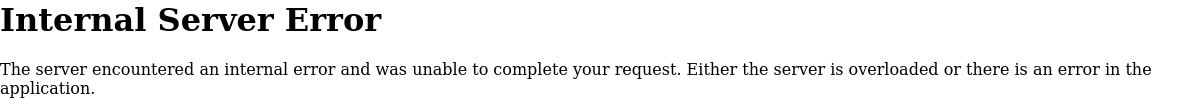

pythonanywhere: catherinele.pythonanywhere.com

**Sources:**

Installation Flask on Linux: 

https://linuxize.com/post/how-to-install-flask-on-ubuntu-20-04/

Heroku on Linux: 

https://stackabuse.com/deploying-a-flask-application-to-heroku/